# Import packages and data

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from sklearn.tree import export_graphviz
from IPython.display import Image
from scipy import stats
from statistics import multimode

In [53]:
# get all data from GitHub repo
files = ['er','ed','futures','infswp','sofr','yields','ez_cds']
file_dict = {}

for file in files:
  file_dict[file] = pd.read_csv('https://raw.githubusercontent.com/sjv1030/wq-capstone/main/data/'+file+'.csv')
  file_dict[file]['Date'] = pd.to_datetime(file_dict[file]['Date'], format='%m/%d/%Y')
  file_dict[file].set_index('Date', inplace=True)
  file_dict[file] = file_dict[file].loc[:'2024-02'].copy()
  file_dict[file].columns = file_dict[file].columns.str.strip()
  #print(file_dict[file].info())
  #display(file_dict[file].head())

# Data transformation

In [54]:
# Initial training period (year)
beg = 2010
end = 2015

## Convert STIR into yield term

Cycle through all contracts and get difference between Eurodollar futures and SOFR futures. For each contract, identify the date where the absolute delta between the Eurodollar and SOFR contract prices is minimized. This date will be used to merge the two contracts in the next step.

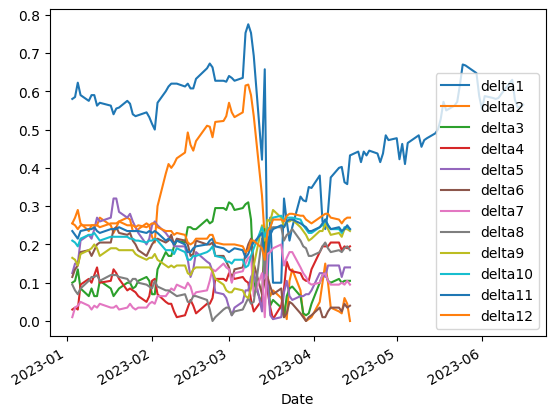

In [55]:
merge_ed_sfr = dict()
for k in range(1,13):
  _ = pd.concat([file_dict['ed'][['ED'+str(k)]], file_dict['sofr'][['SFR'+str(k)]]], axis=1)
  _['delta'+str(k)] = np.abs(_['ED'+str(k)] - _['SFR'+str(k)])
  _['delta'+str(k)].loc['2023':'2023'].dropna().plot(legend=True)
  dates = (_['delta'+str(k)].loc['2023':'2023'].index[_['delta'+str(k)].loc['2023':'2023'].dropna().argmin()],
           _['delta'+str(k)].loc['2023':'2023'].index[_['delta'+str(k)].loc['2023':'2023'].dropna().argmin()+1])
  merge_ed_sfr[k] = dates

plt.show()


In [56]:
# merge ED and SFR futures
backdated_SFR = pd.DataFrame()
for k in range(1,13):
  merge_date, merge_date_1 = merge_ed_sfr[k]
  tmp = pd.concat([file_dict['ed']['ED'+str(k)].loc[:merge_date],
                    file_dict['sofr']['SFR'+str(k)].loc[merge_date_1:]], axis=0
  )
  backdated_SFR['SFR'+str(k)] = tmp


Calculate calendar spreads for the STIR futures. The result is in yield terms.

Short-term interest rate (STIR) futures are quoted in price terms.
Given standard contract conventions, 100 less the price equates to a yield in percent form. Arguably, for macro/fixed-income investment ideas, the yield is more important.

Note that a term spread is usually calculated with the longer duration security first.

For example, the US Yield Curve can be defind as 10-year US Treasury less the 2-year US Treasury
But with STIR futures, one can reverse the order to get the term spread in yield terms.

Example - Using prices from Jan 9, 2023:

*   SFR4's price was 95.405 (or 4.595%)
*   SFR8's price was 96.790 (or 3.21%)

One can calculate the term spread as SFR4 - SFR8, or -1.385%
Note: the term spread is negative because the curve is inverted

In [57]:
# calculate STIR calendar spreads
tmp_dict = {}
for i in range(1,12):
  for j in range(2,13):
    if i < j:
      tmp_dict['ER'+str(i)+'-'+str(j)] = file_dict['er']['ER'+str(i)] - file_dict['er']['ER'+str(j)]
      tmp_dict['SFR'+str(i)+'-'+str(j)] = backdated_SFR['SFR'+str(i)] - backdated_SFR['SFR'+str(j)]

# save data to a dataframe
full_data = pd.DataFrame.from_dict(tmp_dict)

In [58]:
# calculate cross country spreads at key tenors and add to main dataframe
tmp_dict = {}
for i in range(4,13,2):
  tmp_dict['SFRER'+str(i)] = backdated_SFR['SFR'+str(i)] - file_dict['er']['ER'+str(i)]

full_data = full_data.join(pd.DataFrame.from_dict(tmp_dict), how='left')

## Create spreads


Below is a large dictionary holding all of the various spreads to be used as either a target or within the feature set.

In [59]:
file_dict['spread'] = pd.DataFrame()

file_dict['spread']['US302'] = file_dict['yields']['US30'] - file_dict['yields']['US2']
file_dict['spread']['US305'] = file_dict['yields']['US30'] - file_dict['yields']['US5']
file_dict['spread']['US3010'] = file_dict['yields']['US30'] - file_dict['yields']['US10']
file_dict['spread']['US102'] = file_dict['yields']['US10'] - file_dict['yields']['US2']
file_dict['spread']['US105'] = file_dict['yields']['US10'] - file_dict['yields']['US5']
file_dict['spread']['US52'] = file_dict['yields']['US5'] - file_dict['yields']['US2']

file_dict['spread']['DE302'] = file_dict['yields']['DE30'] - file_dict['yields']['DE2']
file_dict['spread']['DE305'] = file_dict['yields']['DE30'] - file_dict['yields']['DE5']
file_dict['spread']['DE3010'] = file_dict['yields']['DE30'] - file_dict['yields']['DE10']
file_dict['spread']['DE102'] = file_dict['yields']['DE10'] - file_dict['yields']['DE2']
file_dict['spread']['DE105'] = file_dict['yields']['DE10'] - file_dict['yields']['DE5']
file_dict['spread']['DE52'] = file_dict['yields']['DE5'] - file_dict['yields']['DE2']

file_dict['spread']['CA102'] = file_dict['yields']['CA10'] - file_dict['yields']['CA2']
file_dict['spread']['CA105'] = file_dict['yields']['CA10'] - file_dict['yields']['CA5']
file_dict['spread']['CA52'] = file_dict['yields']['CA5'] - file_dict['yields']['CA2']

file_dict['spread']['ITDE10'] = file_dict['yields']['IT10'] - file_dict['yields']['DE10']
file_dict['spread']['USDE2'] = file_dict['yields']['US2'] - file_dict['yields']['DE2']
file_dict['spread']['USDE5'] = file_dict['yields']['US5'] - file_dict['yields']['DE5']
file_dict['spread']['USDE10'] = file_dict['yields']['US10'] - file_dict['yields']['DE10']

file_dict['spread']['USEZINF2'] = file_dict['infswp']['US-2'] - file_dict['infswp']['EZ-2']
file_dict['spread']['USEZINF5'] = file_dict['infswp']['US-5'] - file_dict['infswp']['EZ-5']
file_dict['spread']['USEZINF10'] = file_dict['infswp']['US-10'] - file_dict['infswp']['EZ-10']

file_dict['spread']['USINF102'] = file_dict['infswp']['US-10'] - file_dict['infswp']['US-2']
file_dict['spread']['USINF105'] = file_dict['infswp']['US-10'] - file_dict['infswp']['US-5']
file_dict['spread']['USINF52'] = file_dict['infswp']['US-5'] - file_dict['infswp']['US-2']

file_dict['spread']['EZINF102'] = file_dict['infswp']['EZ-10'] - file_dict['infswp']['EZ-2']
file_dict['spread']['EZINF105'] = file_dict['infswp']['EZ-10'] - file_dict['infswp']['EZ-5']
file_dict['spread']['EZINF52'] = file_dict['infswp']['EZ-5'] - file_dict['infswp']['EZ-2']

In [60]:
# STIR futures strictly follow US trading days, so the other dataframe holding spreads (calculated above) will be merged with this one
full_data = full_data.join(file_dict['spread'], how='left')
full_data.head()

,ER1-2,SFR1-2,ER1-3,SFR1-3,ER1-4,SFR1-4,ER1-5,SFR1-5,ER1-6,SFR1-6,...,USDE10,USEZINF2,USEZINF5,USEZINF10,USINF102,USINF105,USINF52,EZINF102,EZINF105,EZINF52
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.360,0.280,0.73,0.660,1.065,1.075,1.330,1.475,1.570,1.865,...,0.4245,-0.1402,0.1875,0.3408,1.2420,0.4343,0.8077,0.761,0.281,0.480
2010-01-05,0.335,0.245,0.70,0.610,1.025,1.005,1.295,1.385,1.540,1.760,...,0.3878,-0.1469,0.1775,0.3362,1.2381,0.4437,0.7944,0.755,0.285,0.470
2010-01-06,0.330,0.225,0.69,0.585,1.015,0.990,1.290,1.385,1.545,1.770,...,0.4405,-0.1489,0.2100,0.3565,1.2634,0.4395,0.8239,0.758,0.293,0.465
2010-01-07,0.310,0.225,0.66,0.590,0.985,1.005,1.260,1.415,1.525,1.810,...,0.4535,-0.1495,0.1345,0.3671,1.2396,0.5006,0.7390,0.723,0.268,0.455
2010-01-08,0.300,0.190,0.64,0.520,0.955,0.925,1.230,1.330,1.500,1.735,...,0.4447,-0.1539,0.1870,0.3820,1.2429,0.4570,0.7859,0.707,0.262,0.445


## PCA for EZ CDS

In [61]:
# this function will be leveraged in the work-forward analysis
# to test the Italian-German 10-year spread

def make_pca(df, beg, end):
  '''
  Function creates a risk index from PCA loadings.
  '''
  cds = df.fillna(method='ffill').iloc[beg:end].diff().dropna().values
  scaler = StandardScaler()
  scaled_cds = scaler.fit_transform(cds)

  pca = PCA(n_components=3)

  pc = pca.fit_transform(scaled_cds)

  # multiply PCA loadings with scaled underlying data
  scaled_cds_array = np.array(scaled_cds)
  scaled_loadings = np.dot(scaled_cds_array, pca.components_.T)

  # multiply "scaled loadings" with principal component weights, respectively
  # to create one index that combines all three principal components
  # this index had to be negated to make it comparable with underlying CDS data

  EZ_risk_index = -np.dot(scaled_loadings, pca.explained_variance_)
  EZ_risk = pd.DataFrame(EZ_risk_index.cumsum(), index=file_dict['ez_cds'].loc[str(beg):str(end)].index[1:])
  EZ_risk.columns = ['EZ Risk Index']
  return EZ_risk

[0.79710824 0.06344893 0.0474346 ]
[0.79710824 0.86055718 0.90799178]


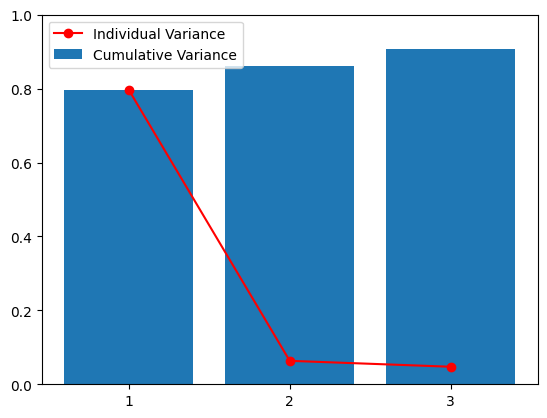

In [62]:
cds = file_dict['ez_cds'].fillna(method='ffill').loc[str(beg):str(end)].diff().dropna().values
scaler = StandardScaler()
scaled_cds = scaler.fit_transform(cds)

pca = PCA(n_components=3)

pc = pca.fit_transform(scaled_cds)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

plt.bar([1,2,3], pca.explained_variance_ratio_.cumsum())
plt.plot([1,2,3], pca.explained_variance_ratio_, color='red', marker='o')
plt.legend(['Individual Variance', 'Cumulative Variance'])
plt.ylim([0,1])
plt.xticks(np.arange(1, 3.1, step=1))
plt.show()

,PC1,PC2,PC3
CS,-0.332928,0.489366,-0.406352
UBS,-0.340347,0.445255,-0.250894
Unicredit,-0.360917,-0.286906,0.261056
BancoSantander,-0.355794,-0.435571,-0.368675
BNP,-0.360980,0.207153,0.406358
Intesa,-0.362388,-0.283121,0.301347
SocGen,-0.357243,0.246761,0.397034
BBVA,-0.356677,-0.325993,-0.392792


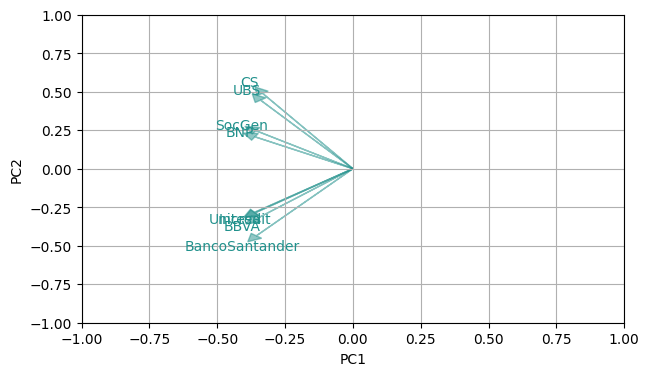

In [63]:
# visualize the loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=file_dict['ez_cds'].columns)
display(loadings)

def loading_plot(coeff, labels):
    n = coeff.shape[0]
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], head_width = 0.05, head_length = 0.05, color = '#21918C',alpha = 0.5)
        plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = '#21918C', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid()

fig, ax = plt.subplots(figsize = (7,4))
loading_plot(pca.components_.T, file_dict['ez_cds'].columns)
plt.show()

In [64]:
# multiply PCA loadings with scaled underlying data
scaled_cds_array = np.array(scaled_cds)
scaled_loadings = np.dot(scaled_cds_array, pca.components_.T)

# multiply "scaled loadings" with principal component weights, respectively
# to create one index that combines all three principal components
# this index had to be negated to make it comparable with underlying CDS data

EZ_risk_index = -np.dot(scaled_loadings, pca.explained_variance_)

The risk index created using the PCA loadings and scaled CDS data aligns well with the underlying CDS data, suggesting it is capturing a large amount of the common variation.

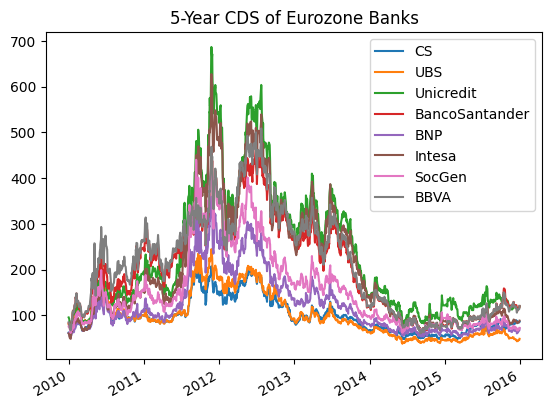

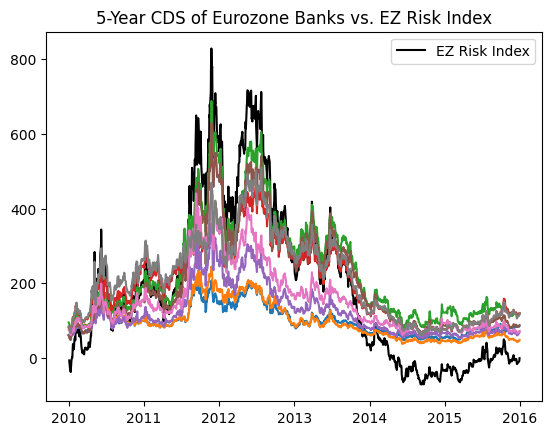

In [65]:
file_dict['ez_cds'].loc['2010':'2015'].plot(legend=True)
plt.title('5-Year CDS of Eurozone Banks')
plt.xlabel('')
plt.show()

plt.plot(file_dict['ez_cds'].loc['2010':'2015'].index[1:], EZ_risk_index.cumsum(),
         label='EZ Risk Index', color='k')
plt.title('5-Year CDS of Eurozone Banks vs. EZ Risk Index')
plt.legend()
plt.plot(file_dict['ez_cds'].loc['2010':'2015'])
plt.show()


In [66]:
# create PCA index and add to larger datafile
EZ_risk = pd.DataFrame(EZ_risk_index.cumsum(), index=file_dict['ez_cds'].loc[str(beg):str(end)].index[1:])
EZ_risk.columns = ['EZ Risk Index']

full_data = full_data.join(EZ_risk, how='left')
full_data.head()

,ER1-2,SFR1-2,ER1-3,SFR1-3,ER1-4,SFR1-4,ER1-5,SFR1-5,ER1-6,SFR1-6,...,USEZINF2,USEZINF5,USEZINF10,USINF102,USINF105,USINF52,EZINF102,EZINF105,EZINF52,EZ Risk Index
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.360,0.280,0.73,0.660,1.065,1.075,1.330,1.475,1.570,1.865,...,-0.1402,0.1875,0.3408,1.2420,0.4343,0.8077,0.761,0.281,0.480,-6.032458
2010-01-05,0.335,0.245,0.70,0.610,1.025,1.005,1.295,1.385,1.540,1.760,...,-0.1469,0.1775,0.3362,1.2381,0.4437,0.7944,0.755,0.285,0.470,-13.249000
2010-01-06,0.330,0.225,0.69,0.585,1.015,0.990,1.290,1.385,1.545,1.770,...,-0.1489,0.2100,0.3565,1.2634,0.4395,0.8239,0.758,0.293,0.465,-18.609869
2010-01-07,0.310,0.225,0.66,0.590,0.985,1.005,1.260,1.415,1.525,1.810,...,-0.1495,0.1345,0.3671,1.2396,0.5006,0.7390,0.723,0.268,0.455,-24.557125
2010-01-08,0.300,0.190,0.64,0.520,0.955,0.925,1.230,1.330,1.500,1.735,...,-0.1539,0.1870,0.3820,1.2429,0.4570,0.7859,0.707,0.262,0.445,-28.489559


# EDA

In [67]:
# convert dataset to weekly at Friday observations
full_data_wf = full_data.resample('W-FRI').last()
full_data_wf.head()

,ER1-2,SFR1-2,ER1-3,SFR1-3,ER1-4,SFR1-4,ER1-5,SFR1-5,ER1-6,SFR1-6,...,USEZINF2,USEZINF5,USEZINF10,USINF102,USINF105,USINF52,EZINF102,EZINF105,EZINF52,EZ Risk Index
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-08,0.300,0.190,0.640,0.520,0.955,0.925,1.230,1.330,1.500,1.735,...,-0.1539,0.187,0.3820,1.2429,0.4570,0.7859,0.7070,0.2620,0.4450,-28.489559
2010-01-15,0.255,0.135,0.555,0.425,0.835,0.800,1.080,1.185,1.335,1.560,...,-0.1330,0.172,0.3620,1.1630,0.4550,0.7080,0.6680,0.2650,0.4030,-4.216823
2010-01-22,0.225,0.110,0.500,0.370,0.780,0.730,1.035,1.100,1.285,1.470,...,-0.1117,0.162,0.3596,1.0828,0.4616,0.6212,0.6115,0.2640,0.3475,37.882832
2010-01-29,0.265,0.115,0.550,0.355,0.820,0.700,1.060,1.080,1.290,1.460,...,0.0622,0.349,0.4609,1.1869,0.5151,0.6718,0.7882,0.4032,0.3850,50.322446
2010-02-05,0.235,0.105,0.445,0.305,0.660,0.610,0.860,0.950,1.070,1.300,...,0.0557,0.323,0.4303,1.1296,0.4873,0.6423,0.7550,0.3800,0.3750,83.084923


## Correlations

Intuitively, the various permutations of spreads calculated for the STIR futures above will have a high level of correlation amongst themselves.

As a result, the correlation heatmaps below focused on the yield spreads.

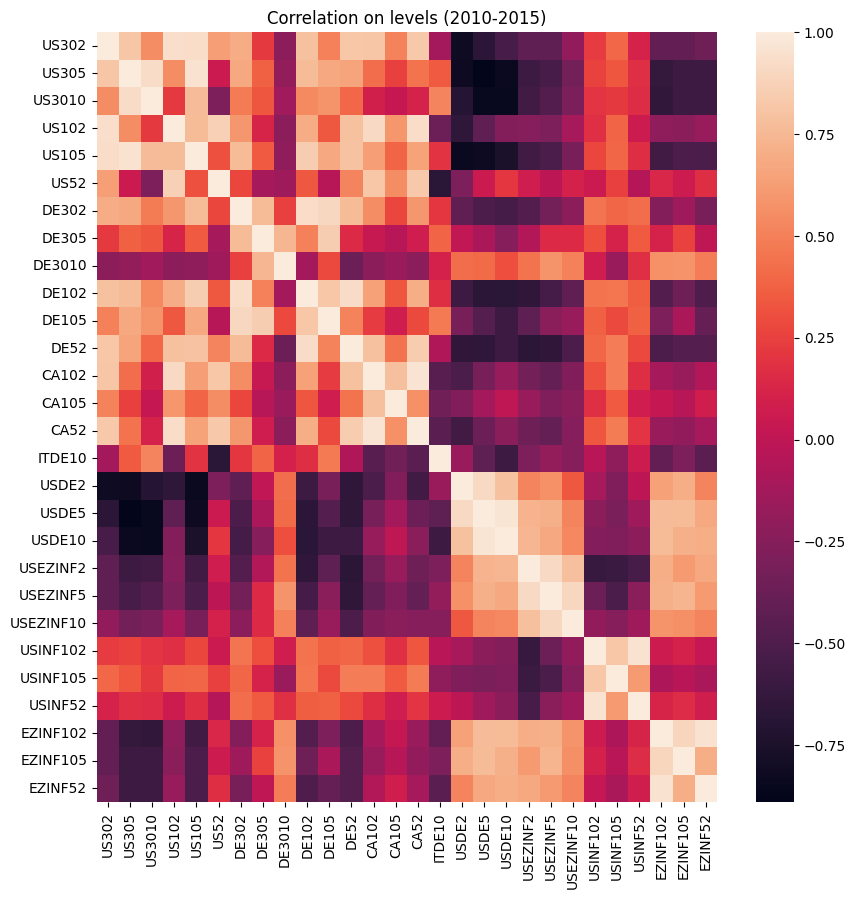

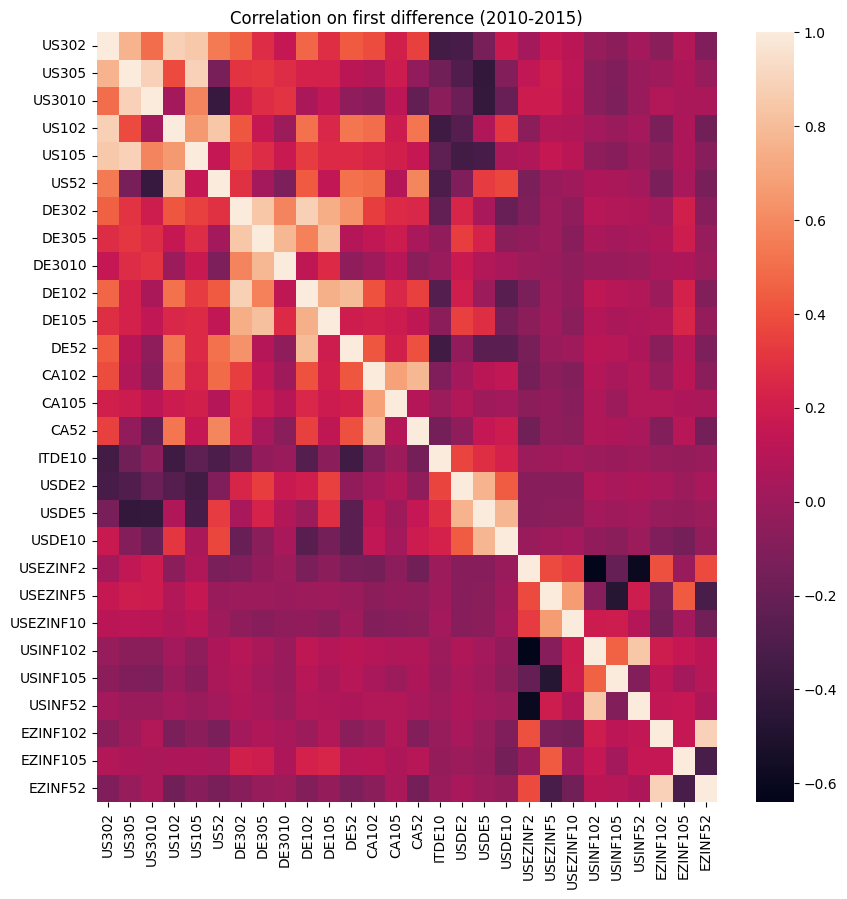

In [71]:
spreads_cols = file_dict['spread'].columns
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(full_data_wf[spreads_cols].loc[str(beg):str(end)].corr(method='pearson').round(2))
plt.title('Correlation on levels ('+str(beg)+'-'+str(end)+')')
plt.show()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(full_data_wf[spreads_cols].loc[str(beg):str(end)].diff().corr(method='pearson').round(2))
plt.title('Correlation on first difference ('+str(beg)+'-'+str(end)+')')
plt.show()

## Plots of raw data

Given the high number of features, only some will be charted for illustration.

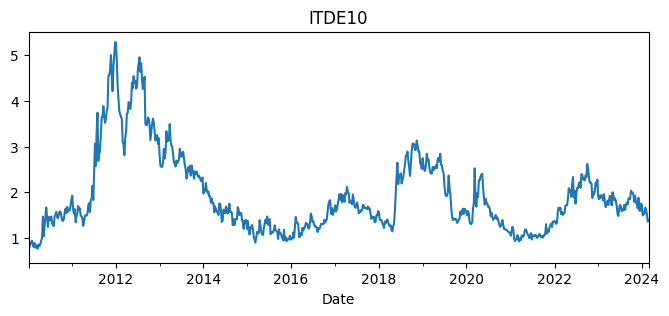

In [79]:
# Plot example of elevated term spread during periods of high macro risk
# like the Italian-German 10-year spread during the Eurozone debt crisis in 2011
plt.figure(figsize=(8,3))
full_data_wf['ITDE10'].plot(title='ITDE10')
plt.show()

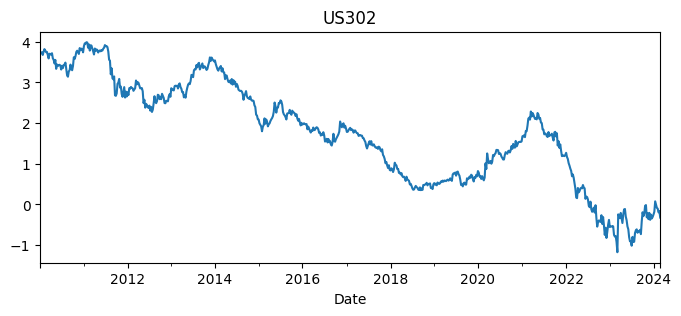

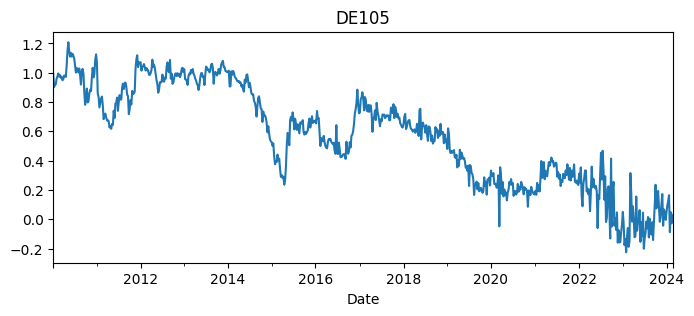

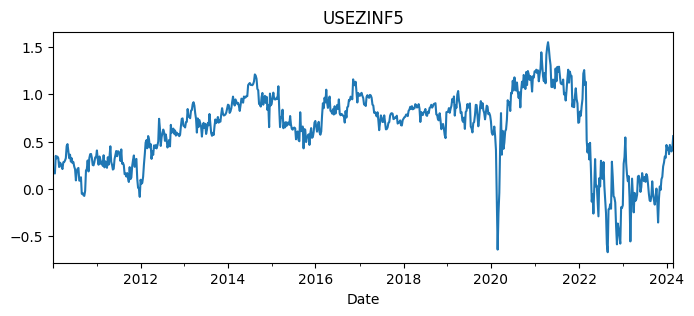

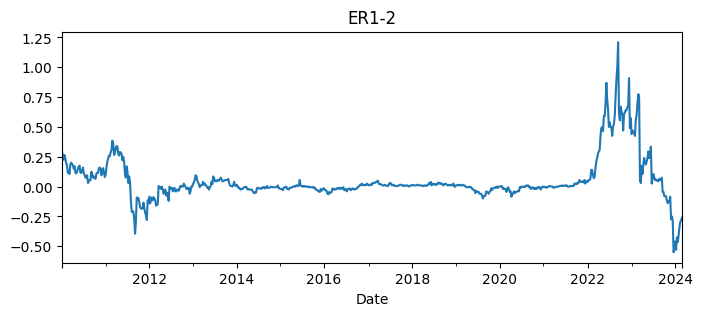

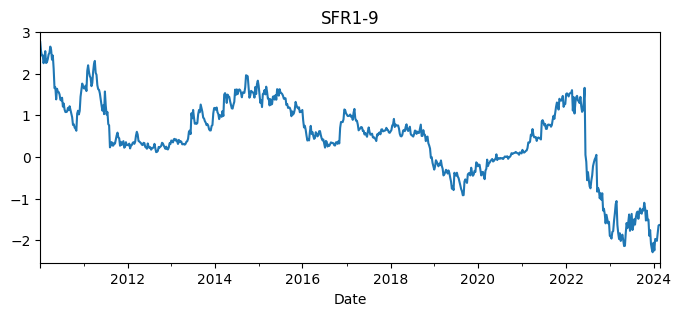

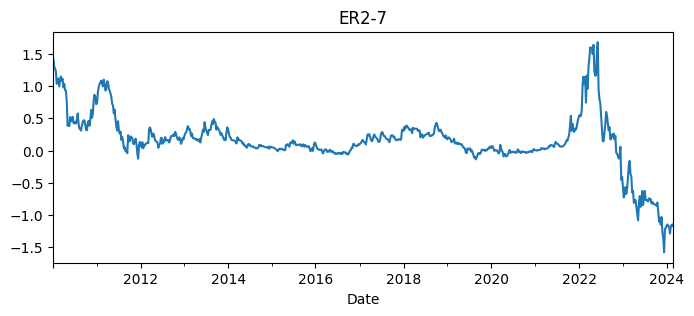

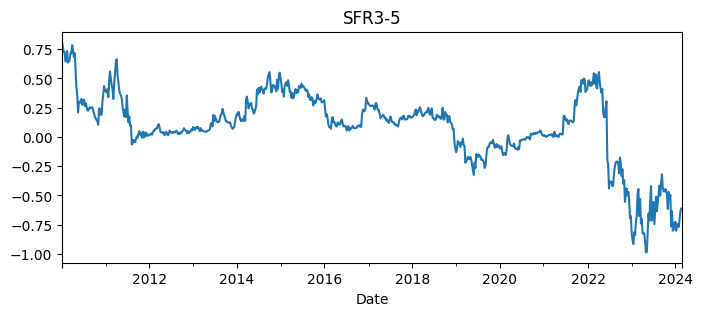

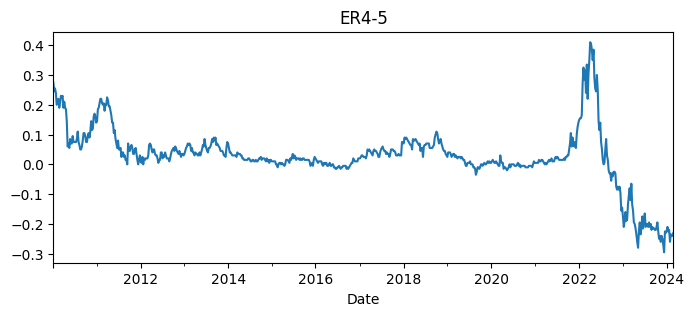

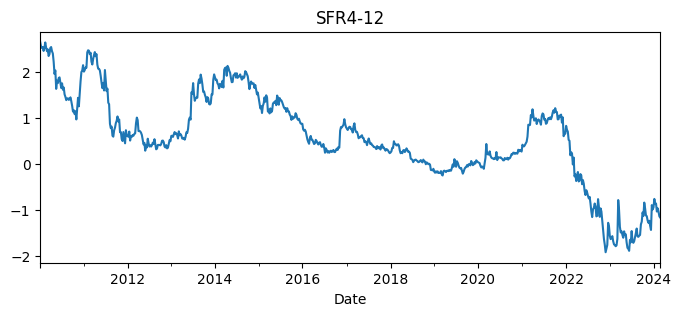

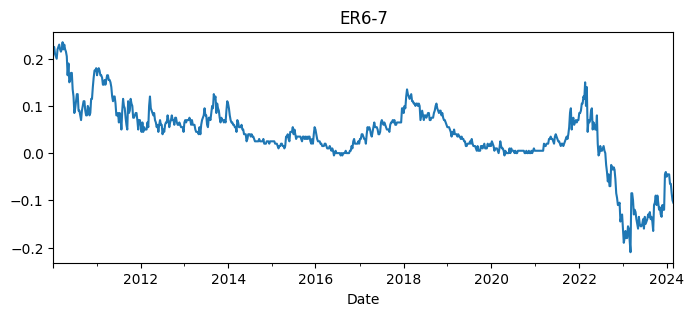

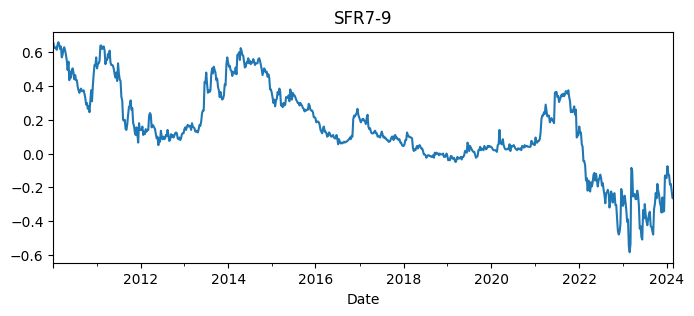

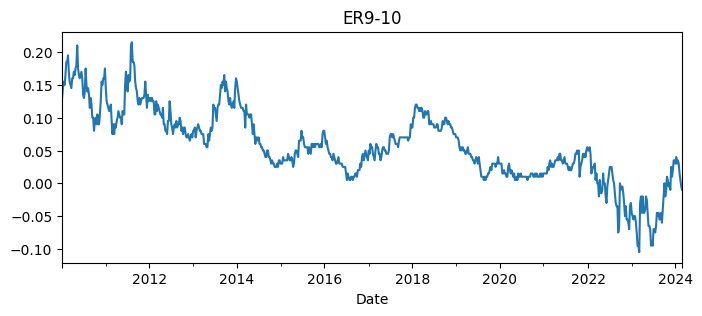

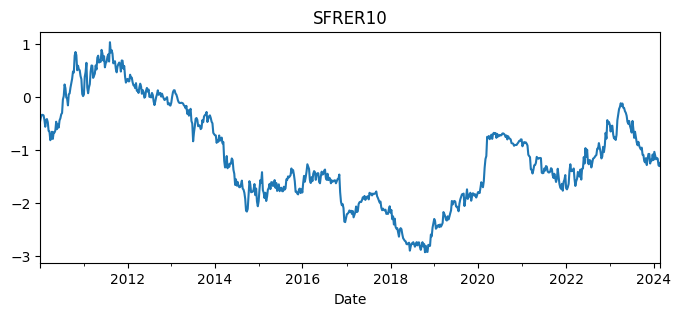

In [78]:
for c, col in enumerate(spreads_cols):
    if c % 10 == 0:
      plt.figure(figsize=(8,3))
      full_data_wf[col].plot(title=col)
      plt.show()
for c, col in enumerate(full_data_wf.drop(spreads_cols, axis=1).columns):
    if c % 15 == 0:
      plt.figure(figsize=(8,3))
      full_data_wf[col].plot(title=col)
      plt.show()

## Check for stationarity

In [72]:
def adf_test(x):
    dftest = adfuller(x.dropna(),autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Numer of Observations Used'])
    print(dfoutput.round(3))

def run_eda(df):
  for col in df.columns:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))

    df[col].plot(title=col, ax=axes[0])
    sns.histplot(ax=axes[1], data=df,x=col)
    axes[1].set_title('Distribution')
    plot_acf(df[col].dropna(), ax=axes[2])
    axes[2].set_title('Autocorrelation')
    plt.tight_layout()

  for col in df.columns:
    print('Running ADF on '+col+'\n')
    adf_test(df[col])
    print('----------------------------------------')

Run ADF on all the target variables. While the target does not need to be stationary (since it will be converted to a categorical variable), the ADF will help inform if lags of the target should be included in the feature dataset.

The results suggest all target variables have serial correlation and are not stationary.

Note that the data was contained to 2010-2015 to avoid look ahead bias.

Running ADF on US102

Test Statistic                -11.664
p-value                         0.000
#Lags Used                      1.000
Numer of Observations Used    309.000
dtype: float64
----------------------------------------
Running ADF on DE102

Test Statistic                 -6.208
p-value                         0.000
#Lags Used                      5.000
Numer of Observations Used    305.000
dtype: float64
----------------------------------------
Running ADF on USDE10

Test Statistic                -10.15
p-value                         0.00
#Lags Used                      4.00
Numer of Observations Used    306.00
dtype: float64
----------------------------------------
Running ADF on SFRER4

Test Statistic                 -3.553
p-value                         0.007
#Lags Used                     12.000
Numer of Observations Used    298.000
dtype: float64
----------------------------------------
Running ADF on SFRER6

Test Statistic                 -4.116
p-value              

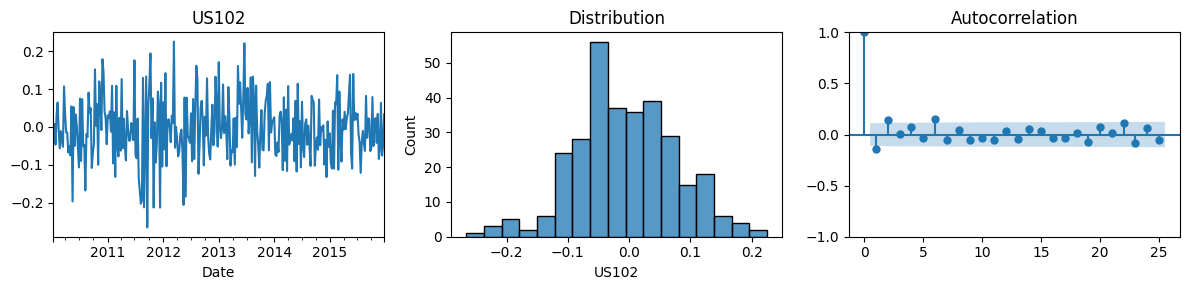

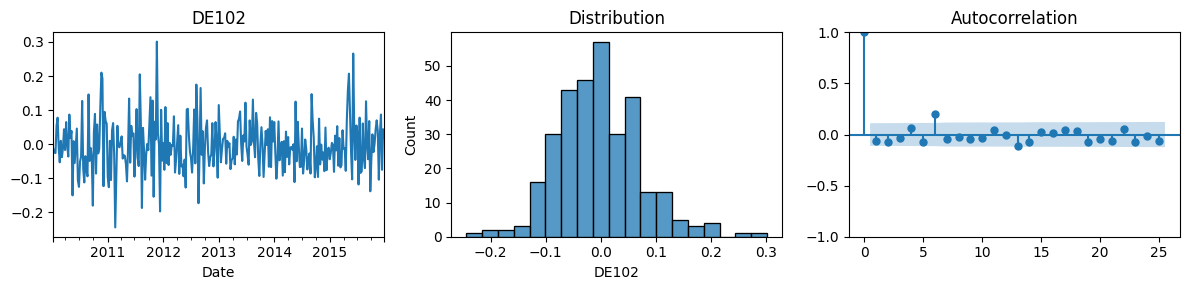

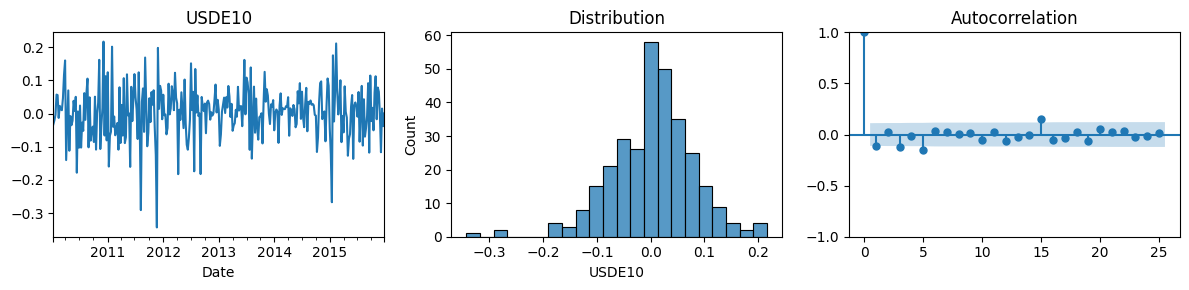

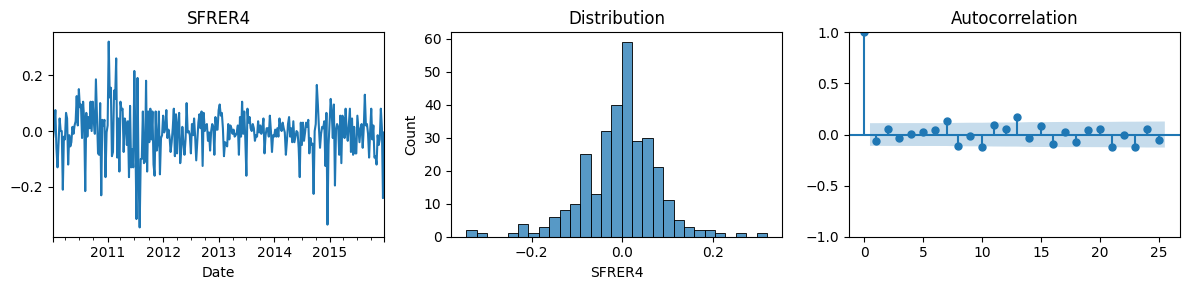

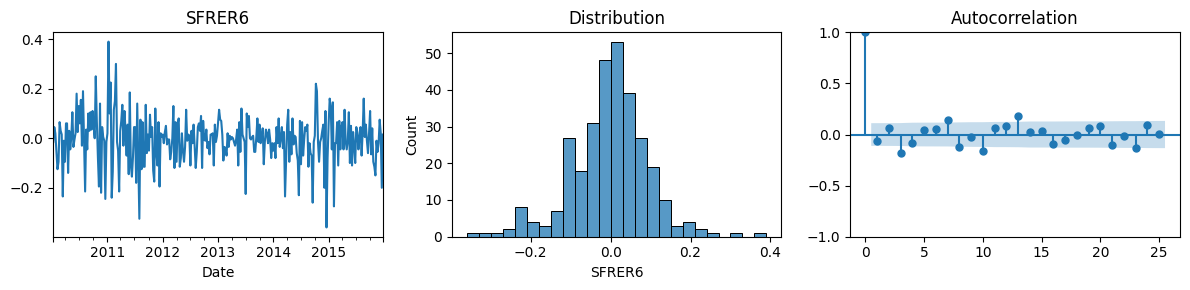

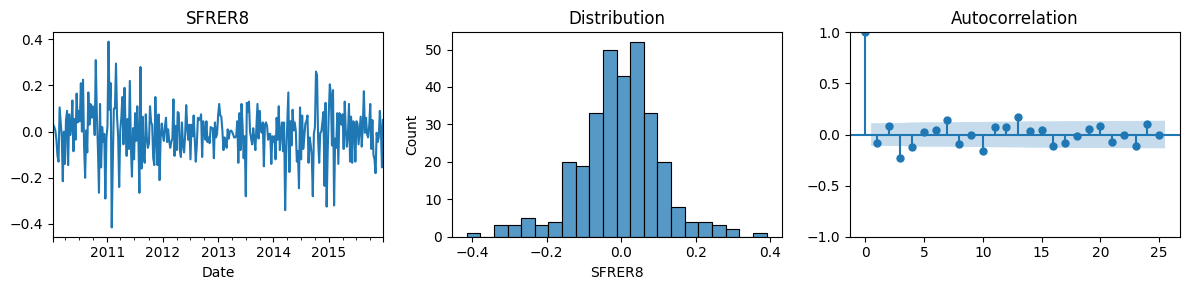

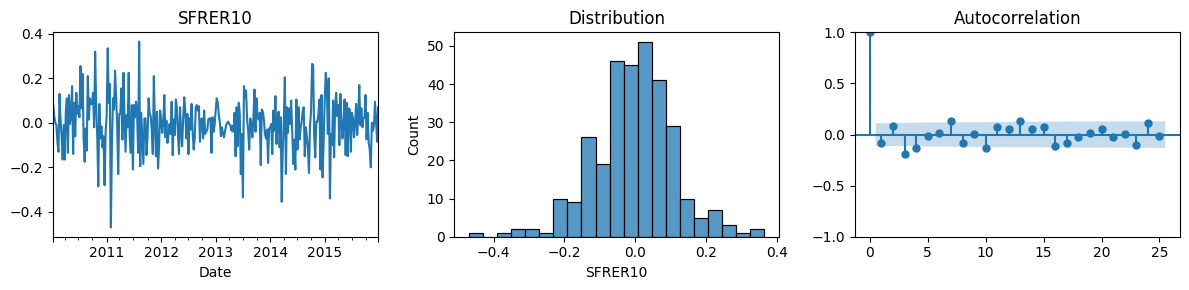

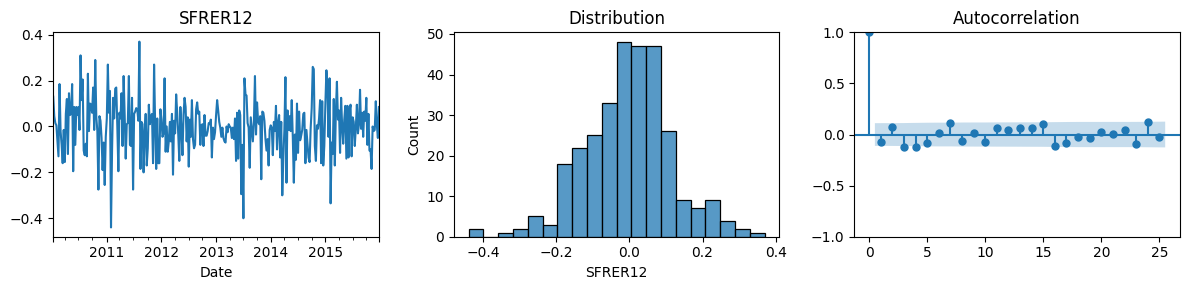

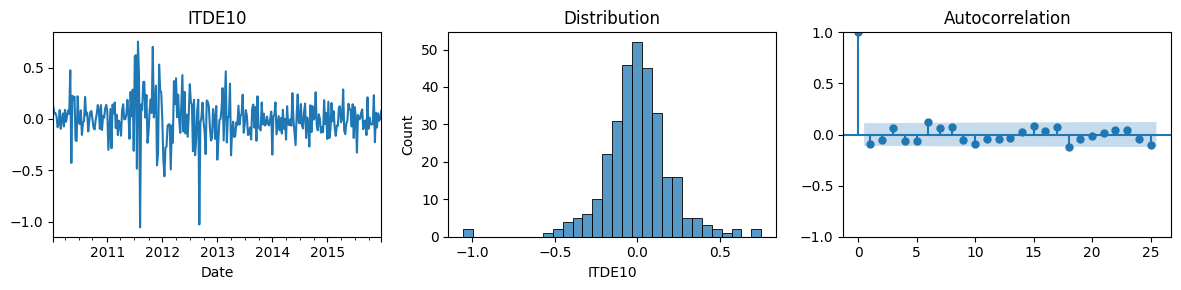

In [80]:
target_list = ['US102','DE102','USDE10','SFRER4','SFRER6','SFRER8','SFRER10','SFRER12','ITDE10']
for tgt in target_list:
  run_eda(full_data_wf[[tgt]].loc[str(beg) : str(end)].diff()[1:])

# Model Selection & Backtest

Test various classification models (i.e., SVC, Logit, Random Forest) to see which model best predicts an up or down move in a position in a walk-forward analysis.

In [23]:
DV01 = 10000
aum = 1000000

In [24]:
def lag_feature(df, features, target):
  '''
  Function takes a pandas dataframe and inserts lags of all columns.
  Returns a dataframe with all lags inserted, first differenced,
  and a target series as a categorical variable.
  '''
  df = df[features + target].fillna(method='ffill').copy()
  tmp_dict = dict()
  for col in df.columns:
    for l in range(1,5):
      tmp_col = df[col].shift(l).copy()
      tmp_dict[col+'L'+str(l)] = tmp_col
  df = pd.concat([df,
                 pd.DataFrame.from_dict(tmp_dict)],
                 axis=1
  )
  df.dropna(inplace=True)

  X = df.diff()[1:].fillna(method='ffill').drop(target, axis=1)
  y = df[target].diff()[1:].fillna(method='ffill')

  upper = 0.05
  lower = -0.05
  y = pd.DataFrame(np.where(y > upper, 1, np.where(y < lower, -1, 0)))
  return X, y



def filter(X, y, beg, end):
  '''
  Function takes the target and features, as well as
  beginning and ending index values as integers.

  Returns target and features over selected time period.
  '''
  X = X.iloc[beg : end].copy()
  y = pd.DataFrame(y).iloc[beg : end].values
  return X, y

def train_logit(X, y):
  '''
  Function takes a feature dataframe and target series,
  and returns a logistic regression model.
  '''
  log = LogisticRegression(solver='saga', multi_class='multinomial')
  log.fit(X, np.reshape(y,-1))
  return log

def valid_logit(X, y, model):
  '''
  Function takes a feature dataframe, target series, and logistic regression
  model, and returns the model score.
  '''
  y_pred = model.predict(X)
  score = model.score(X, y)
  return score

def train_valid_rfc(train_X, train_y, valid_X, valid_y):
  '''
  Function takes a feature dataframe and target series for both the training
  period and validation period.

  A Random Forest Classifier model is trained with some hyperparameter tuning.
  The best model is chosen with the highest F1 score using the validation data.

  The function returns the best model, score, and number of estimators.
  '''
  best_n = 0
  best_score = 0
  for i in range(100, 300, 50):
    rfc = RandomForestClassifier(random_state=51, n_estimators=i)
    rfc.fit(train_X, np.reshape(train_y,-1))
    y_pred = rfc.predict(valid_X)
    tmpf1 = metrics.f1_score(valid_y, y_pred, average='weighted')
    if tmpf1 > best_score:
      best_score = tmpf1
      best_n = i
      best_model = rfc
  return best_model, best_score, best_n

def train_valid_svc(train_X, train_y, valid_X, valid_y):
  '''
  Function takes a feature dataframe and target series for both the training
  period and validation period.

  A Support Vector Classification model is trained with some hyperparameter
  tuning. The best model is chosen with the highest F1 score using the
  validation data.

  The function returns the best model, score, and regularization parameter.
  '''
  best_n = 0
  best_score = 0
  for i in range(1, 1000, 50):
    svc_model = SVC(random_state=51, C=i, kernel='rbf', gamma='auto')
    svc_model.fit(train_X, np.reshape(train_y,-1))
    y_pred = svc_model.predict(valid_X)
    tmpf1 = metrics.f1_score(valid_y, y_pred, average='weighted')
    if tmpf1 > best_score:
      best_score = tmpf1
      best_n = i
      best_model = svc_model
  return best_model, best_score, best_n

def get_bt_stats(_dict, target, DV01, aum):
  '''
  Show backtest results
  '''
  positions = pd.DataFrame.from_dict(_dict, orient='index')
  positions.columns = ['Position']
  positions = positions.join(full_data_wf[target].diff().loc[positions.index], how='left')
  positions['Position'] = positions['Position'].shift(1).fillna(0)
  positions['cum_position'] = positions['Position']

  for r in range(1, positions.shape[0]):
    if positions['cum_position'].iloc[r-1] == 1 and positions['Position'].iloc[r] == 0:
      positions['cum_position'].iloc[r] = 1
    if positions['cum_position'].iloc[r-1] == -1 and positions['Position'].iloc[r] == 0:
      positions['cum_position'].iloc[r] = -1


  positions['trade'] = positions[['cum_position']] *  positions[target].values
  #positions['trade'] = positions[['Position']] *  positions[target].values
  positions['pnl'] = positions['trade'] * 100 * DV01
  positions['pnl'].iloc[0] = aum
  positions['cum_pnl'] = positions['pnl'].cumsum()
  positions['return'] = positions['cum_pnl'].pct_change()
  positions['cum_return'] = np.cumprod(1 + positions['return'].fillna(0).values)

  for r in range(2, positions.shape[0]):
    if round(positions['cum_return'].iloc[r-1],2) <= 0.0:
      positions['cum_return'].iloc[r-1] = 0.
      positions['cum_return'].iloc[r] = 0.
    else:
      continue

  # show stats
  _m = positions['return'].mean() * 100 * 52
  _s = positions['return'].std() * 100 * np.sqrt(52)
  print('Annualized Mean Return %:', round(_m,2))
  print('Annualized St Deviation %:', round(_s,2))
  print('Sharpe Ratio assuming rf = 0:', round(_m/_s,2))

  # show cumulative return
  plt.figure(figsize=(8,4))
  plt.plot(positions['cum_return'])
  #plt.plot(positions['cum_pnl']/positions['cum_pnl'][0])
  plt.title('Cumulative Return Multiple on US $1,000,000 for '+target[0])
  plt.xlabel('Date')
  plt.grid(True)
  plt.show()

## Target 1: USYC210

In [25]:
target_1_features = ['US105','US52','USINF102','USINF105','USINF52']
target_1 = ['US102']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_1_features,
                      target_1
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end
)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52
)

score = valid_logit(valid_X,
                    valid_y,
                    log_model
)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.6
Best F1 score for RFC: 0.9
Best number of estimators: 100
Best F1 score for SVC: 0.9
Best C for SVC: 751


### Walk-forward analysis

In [26]:
target_1_wf_dict = dict() # dictionary to save scores
target_1_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_1_features,
                      target_1
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_1_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1))

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_1_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: 28.93
Annualized St Deviation %: 65.91
Sharpe Ratio assuming rf = 0: 0.44


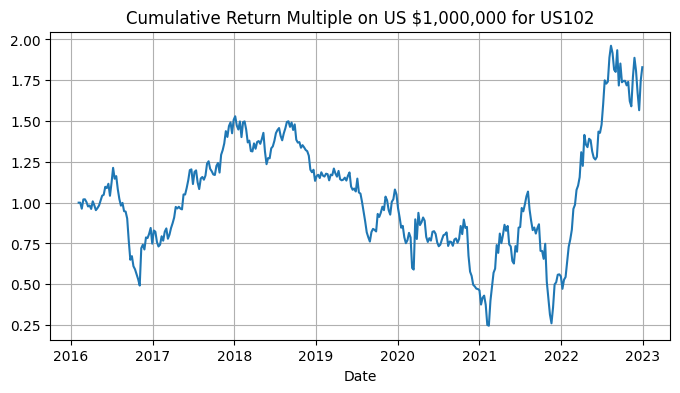

In [27]:
get_bt_stats(target_1_position, target_1, DV01, aum)

## Target 2:DEYC210

In [28]:
target_2_features = ['DE105','DE52','ITDE10','EZINF102','EZINF105','EZINF52']
target_2 = ['DE102']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_2_features,
                      target_2
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.5
Best F1 score for RFC: 0.8
Best number of estimators: 100
Best F1 score for SVC: 0.83
Best C for SVC: 351


### Walk-forward analysis

In [29]:
target_2_wf_dict = dict() # dictionary to save scores
target_2_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_2_features,
                      target_2
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_2_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_2_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: 96.73
Annualized St Deviation %: 163.94
Sharpe Ratio assuming rf = 0: 0.59


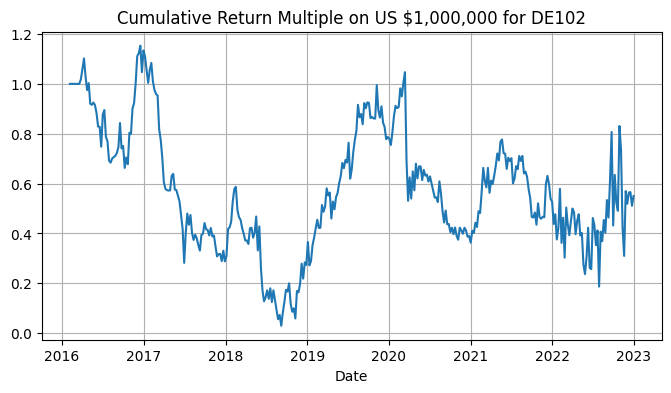

In [30]:
get_bt_stats(target_2_position, target_2, DV01, aum)

## Target 3: USDE10

In [31]:
target_3_features = ['USEZINF2', 'USEZINF5', 'USINF102', 'USINF105', 'USINF52','EZINF102','EZINF105','EZINF52']
target_3 = ['USDE10']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_3_features,
                      target_3
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.38
Best F1 score for RFC: 0.42
Best number of estimators: 100
Best F1 score for SVC: 0.39
Best C for SVC: 601


### Walk-forward analysis

In [32]:
target_3_wf_dict = dict() # dictionary to save scores
target_3_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_3_features,
                      target_3
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_3_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)


  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_3_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: -710.85
Annualized St Deviation %: 1274.36
Sharpe Ratio assuming rf = 0: -0.56


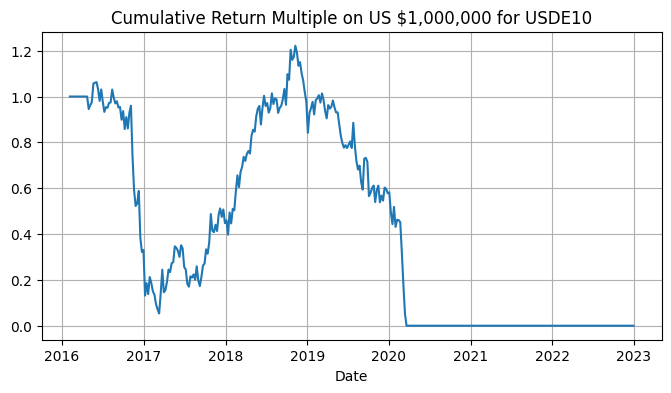

In [33]:
get_bt_stats(target_3_position, target_3, DV01, aum)

## Target 4: SFRER4

In [34]:
target_4_features = ['USEZINF2', 'USEZINF5', 'USEZINF10', 'SFR4-6', 'ER4-6',
                     'USINF52', 'EZINF52', 'USINF102', 'EZINF102', 'USINF105', 'EZINF105',
                     'USDE2','USDE5','USDE10']
target_4 = ['SFRER4']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_4_features,
                      target_4
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.52
Best F1 score for RFC: 0.57
Best number of estimators: 100
Best F1 score for SVC: 0.61
Best C for SVC: 601


### Walk-forward analysis

In [35]:
target_4_wf_dict = dict() # dictionary to save scores
target_4_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_4_features,
                      target_4
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_4_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_4_position[_test_X.index[0]] = _mode[0]

### Backtest results



Annualized Mean Return %: -102945843970296.73
Annualized St Deviation %: 270868434024945.12
Sharpe Ratio assuming rf = 0: -0.38


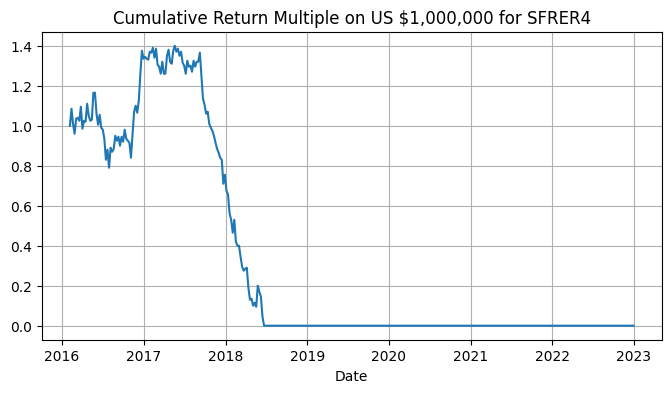

In [36]:
get_bt_stats(target_4_position, target_4, DV01, aum)

## Target 5: SFRER6

In [37]:
target_5_features = ['USEZINF2', 'USEZINF5', 'USEZINF10', 'SFR4-6', 'ER4-6',
                     'USINF52', 'EZINF52', 'USINF102', 'EZINF102', 'USINF105', 'EZINF105',
                     'USDE2','USDE5','USDE10']
target_5 = ['SFRER6']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_5_features,
                      target_5
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.48
Best F1 score for RFC: 0.59
Best number of estimators: 200
Best F1 score for SVC: 0.57
Best C for SVC: 301


### Walk-forward analysis

In [38]:
target_5_wf_dict = dict() # dictionary to save scores
target_5_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_5_features,
                      target_5
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_5_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_5_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: -430.33
Annualized St Deviation %: 1265.09
Sharpe Ratio assuming rf = 0: -0.34


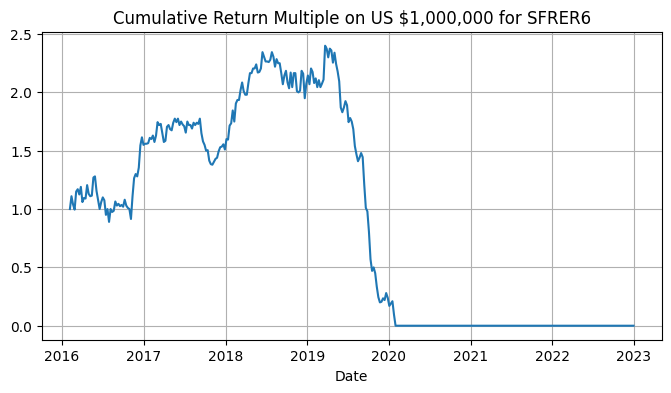

In [39]:
get_bt_stats(target_5_position, target_5, DV01, aum)

## Target 6: SFRER8

In [40]:
target_6_features = ['USEZINF2', 'USEZINF5', 'USEZINF10', 'SFR4-6', 'ER4-6',
                     'USINF52', 'EZINF52', 'USINF102', 'EZINF102', 'USINF105', 'EZINF105',
                     'USDE2','USDE5','USDE10']
target_6 = ['SFRER8']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_6_features,
                      target_6
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.54
Best F1 score for RFC: 0.6
Best number of estimators: 200
Best F1 score for SVC: 0.63
Best C for SVC: 151


### Walk-forward analysis

In [41]:
target_6_wf_dict = dict() # dictionary to save scores
target_6_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_6_features,
                      target_6
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_6_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_6_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: 22.95
Annualized St Deviation %: 35.12
Sharpe Ratio assuming rf = 0: 0.65


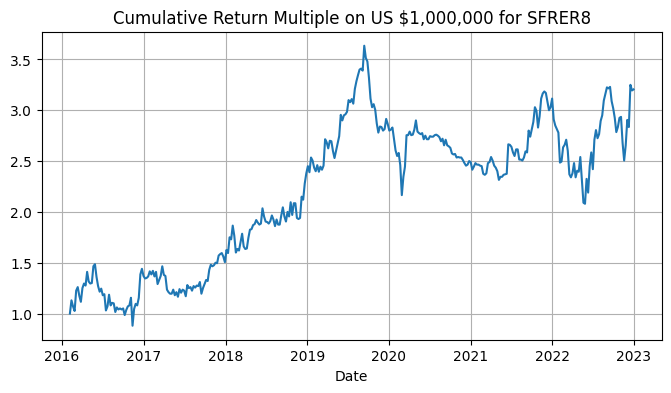

In [42]:
get_bt_stats(target_6_position, target_6, DV01, aum)

## Target 7: SFRER10

In [43]:
target_7_features = ['USEZINF2', 'USEZINF5', 'USEZINF10', 'SFR4-6', 'ER4-6',
                     'USINF52', 'EZINF52', 'USINF102', 'EZINF102', 'USINF105', 'EZINF105',
                     'USDE2','USDE5','USDE10']
target_7 = ['SFRER10']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_7_features,
                      target_7
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.46
Best F1 score for RFC: 0.71
Best number of estimators: 150
Best F1 score for SVC: 0.57
Best C for SVC: 101


### Walk-forward analysis

In [44]:
target_7_wf_dict = dict() # dictionary to save scores
target_7_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_7_features,
                      target_7
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_7_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_7_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: 24.84
Annualized St Deviation %: 66.67
Sharpe Ratio assuming rf = 0: 0.37


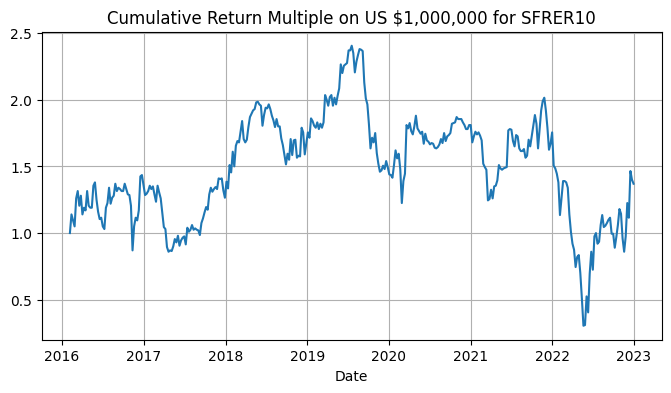

In [45]:
get_bt_stats(target_7_position, target_7, DV01, aum)

## Target 8: SFRER12

In [46]:
target_8_features = ['USEZINF2', 'USEZINF5', 'USEZINF10', 'SFR4-6', 'ER4-6',
                     'USINF52', 'EZINF52', 'USINF102', 'EZINF102', 'USINF105', 'EZINF105',
                     'USDE2','USDE5','USDE10']
target_8 = ['SFRER12']
beg = 0
end = beg+(52*5)

# Get data
_X, _y = lag_feature(full_data_wf.loc[:'2023'],
                      target_8_features,
                      target_8
)

# Run Logit Model
X_, y_ = filter(_X, _y, beg, end)

log_model = train_logit(X_, y_)

valid_X, valid_y = filter(_X, _y, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)

Logit model score: 0.5
Best F1 score for RFC: 0.73
Best number of estimators: 100
Best F1 score for SVC: 0.52
Best C for SVC: 51


### Walk-forward analysis

In [47]:
target_8_wf_dict = dict() # dictionary to save scores
target_8_position = dict() # dictionary to save positions

# Get data
X, y = lag_feature(full_data_wf.loc[:'2023'],
                      target_8_features,
                      target_8
)

for idx in range(0, X.shape[0] - (52*7)):

  _beg = idx
  _end = idx + (52*5)

  if idx % 13 == 0: # refresh models every quarter
    # Run Logit Model
    _X, _y = filter(X, y, beg, end)

    _log_model = train_logit(_X, _y)

    _valid_X, _valid_y = filter(X, y, _end, _end+52)

    _score = valid_logit(_valid_X, _valid_y, _log_model)

    # Run Random Forest Classification Model
    _rfc_model, _rfc_score, _rfc_n = train_valid_rfc(_X, _y, _valid_X, _valid_y)

    # Run SVC Model
    _svc_model, _svc_score, _svc_n = train_valid_svc(_X, _y, _valid_X, _valid_y)

    # Save the scores indexed by ending year of training period
    target_8_wf_dict[X.index[beg]] = [round(_score,2), round(_rfc_score,2), round(_svc_score,2)]

  # Forecast
  _test_X, _test_y = filter(X, y, _end+52, _end+(52+1)
  )

  _log_pred = _log_model.predict(_test_X)
  _rfc_pred = _rfc_model.predict(_test_X)
  _svc_pred = _svc_model.predict(_test_X)

  _mode = multimode([_log_pred[0], _rfc_pred[0], _svc_pred[0]])
  if len(_mode) > 1:
    _mode = [0]

  target_8_position[_test_X.index[0]] = _mode[0]

### Backtest results

Annualized Mean Return %: -552.34
Annualized St Deviation %: 1212.21
Sharpe Ratio assuming rf = 0: -0.46


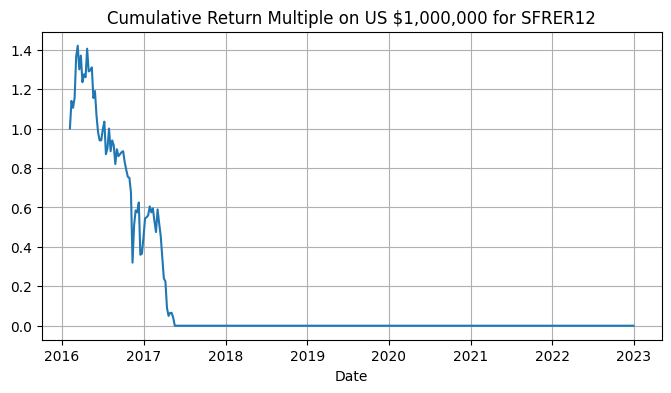

In [48]:
get_bt_stats(target_8_position, target_8, DV01, aum)

# Target 9: ITDE10 -- Ignore

In [49]:
def make_pca(df, beg, end):
  cds = df.fillna(method='ffill').iloc[beg : end].diff().dropna().values
  scaler = StandardScaler()
  scaled_cds = scaler.fit_transform(cds)

  pca = PCA(n_components=3)

  pc = pca.fit_transform(scaled_cds)

  # multiply PCA loadings with scaled underlying data
  scaled_cds_array = np.array(scaled_cds)
  scaled_loadings = np.dot(scaled_cds_array, pca.components_.T)

  # multiply "scaled loadings" with principal component weights, respectively
  # to create one index that combines all three principal components
  # this index had to be negated to make it comparable with underlying CDS data

  EZ_risk_index = -np.dot(scaled_loadings, pca.explained_variance_)
  EZ_risk = pd.DataFrame(EZ_risk_index.cumsum(),
                         index=df.iloc[beg : end].index[1:]
  )
  EZ_risk.columns = ['EZ Risk Index']
  return EZ_risk

def lag_feature_pca(df, features_df, target, beg, end):
  '''
  Function takes a pandas dataframe and inserts lags of all columns.
  Returns a dataframe with all lags inserted, first differenced,
  and a target series as a categorical variable.
  '''
  df = df[target].iloc[beg : end].fillna(method='ffill').copy()
  df_ = make_pca(features_df, beg, end)

  #df = df.join(df_, how='left')

  tmp_dict = dict()
  for col in df_.columns:
    for l in range(1,5):
      tmp_col = df_[col].shift(l).copy()
      tmp_dict[col+'L'+str(l)] = tmp_col
  df_ = pd.concat([df_,
                 pd.DataFrame.from_dict(tmp_dict)],
                 axis=1
  )

  df_ = df_.join(df, how='left')
  df_.dropna(inplace=True)

  X = df_.diff()[1:].fillna(method='ffill').drop(target, axis=1)
  y = df_[target].diff()[1:].fillna(method='ffill')

  upper = 0.05
  lower = -0.05
  y = pd.DataFrame(np.where(y > upper, 1, np.where(y < lower, -1, 0)))
  return X, y

In [50]:
'''
target_9_features = file_dict['ez_cds'].resample('W-FRI').last().copy()
target_9 = ['ITDE10']
beg = 0
end = beg+(52*5)

# Note that this process is slightly different given the PCA feature

# Get data
_X, _y = lag_feature_pca(full_data_wf.loc[:'2023'],
                      target_9_features,
                      target_9, beg, end
)

# Run Logit Model
#X__, y_ = filter(_X, _y, beg, end)

log_model = train_logit(_X, _y)


X_, y_ = lag_feature_pca(full_data_wf.loc[:'2023'],
                      target_9_features,
                      target_9, beg, end+52
)
valid_X, valid_y = filter(X_, y_, end, end+52)

score = valid_logit(valid_X, valid_y, log_model)
print('Logit model score:', round(score,2))

# Run Random Forest Classification Model

rfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)
print('Best F1 score for RFC:', round(rfc_score,2))
print('Best number of estimators:', rfc_n)

# Run SVC Model

svc_model, svc_score, svc_n = train_valid_svc(X_, y_, valid_X, valid_y)
print('Best F1 score for SVC:', round(svc_score,2))
print('Best C for SVC:', svc_n)
'''

"\ntarget_9_features = file_dict['ez_cds'].resample('W-FRI').last().copy()\ntarget_9 = ['ITDE10']\nbeg = 0\nend = beg+(52*5)\n\n# Note that this process is slightly different given the PCA feature\n\n# Get data\n_X, _y = lag_feature_pca(full_data_wf.loc[:'2023'],\n                      target_9_features,\n                      target_9, beg, end\n)\n\n# Run Logit Model\n#X__, y_ = filter(_X, _y, beg, end)\n\nlog_model = train_logit(_X, _y)\n\n\nX_, y_ = lag_feature_pca(full_data_wf.loc[:'2023'],\n                      target_9_features,\n                      target_9, beg, end+52\n)\nvalid_X, valid_y = filter(X_, y_, end, end+52)\n\nscore = valid_logit(valid_X, valid_y, log_model)\nprint('Logit model score:', round(score,2))\n\n# Run Random Forest Classification Model\n\nrfc_model, rfc_score, rfc_n = train_valid_rfc(X_, y_, valid_X, valid_y)\nprint('Best F1 score for RFC:', round(rfc_score,2))\nprint('Best number of estimators:', rfc_n)\n\n# Run SVC Model\n\nsvc_model, svc_score, svc_

# Portfolio Construction

## Equal Weight

## HRP